In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [88]:
def calc_n(k_a, k_e):
    #1) Initialize parameters.
    tmax = 4000 if k_a > 4000 and k_e < 200 else 1500
    dt = 0.05

    #1.1) Neuron/Network pairs.
    c_m = 50 # nF
    v_th = -55 # mV
    v_r = -75 # mV
    g_l = 15 # nS
    e_l = v_r # mV
    v_spike = 20 # mV

    # Bursting parameters
    tau_a = 5 # s
    k_in = 50 # Pa/s

    # PIEZO channel parameters
    g_s = 25 # nS
    e_srev = 10 # mV
    s = .00277 # 1/Pa
    k_b = 106
    m = 25
    q = 1

    #2) Reserve memory
    T = int(np.ceil(tmax / dt))
    v = np.zeros(T)
    sigma_m = np.zeros(T)
    sigma_a = np.zeros(T)
    sigma_w = np.zeros(T)
    i_s = np.zeros(T)

    #2.1) Initialize
    spikes = []
    v[0] = -75 #Resting potential
    sigma_a[0] = 0
    sigma_w[0] = 25000
    sigma_m[0] = sigma_a[0] + sigma_w[0]
    
    #3) For-loop over time.
    for t in np.arange(T-1):
        if v[t] < v_th:
            #3.1) Update DOE.
            i_s[t+1] = g_s / (1 + k_b * np.exp(- s * (sigma_m[t] / m) ** q)) * (v[t] - e_srev)
            i_l = g_l * (v[t] - e_l)
            # update membrane potential
            dv = 1 / c_m * (- i_l - i_s[t])
            v[t+1] = v[t] + dv*dt
            # update active stress
            dsigma_a = - sigma_a[t] / tau_a
            sigma_a[t+1] = sigma_a[t] + dsigma_a * dt
            # update vacuole volume
            dsigma_w = k_in
            sigma_w[t+1] = sigma_w[t] + dsigma_w * dt
        else:
            #3.2) Spike!
            v[t] = 20
            v[t+1] = v_r
            sigma_a[t+1] = sigma_a[t] + k_a
            sigma_w[t+1] = sigma_w[t] - k_e
            i_s[t+1] = i_s[t]
            spikes.append(t*dt)
        
        # update muscle stress
        sigma_m[t+1] = sigma_w[t+1] + sigma_a[t+1]
    
    # Throw the warm-up period
    spikes_ = []
    for x in spikes:
        if x >= 500:
            spikes_.append(x)
    spikes = spikes_
    
    # Clustering
    clusters = []
    intervals = [spikes[i+1] - spikes[i] for i in range(len(spikes) - 1)]
    max_int, min_int = max(intervals), min(intervals)
    
    if min_int >= .9 * max_int:
        return None, None, None # filter out non-bursters
    
    for i, tspike in enumerate(spikes):
        if i == 0 or max_int - (tspike - spikes[i-1]) < .1 * max_int:
            clusters.append([tspike])
        else:
            clusters[-1].append(tspike) 
    
    # Filter out non-bursters
    n = len(clusters)
    m_li = [len(cluster) for cluster in clusters]
    if n == 1 or m_li.count(1) > 2:
        return None, None, None
    
    # Calculate metrics
    
#     cb_total_time = 0
#     cb_pulse_number = 0
#     for cluster in clusters:
#         if cluster[0] > 1000: 
#             break
#         cb_total_time += cluster[-1] - cluster[0]
#         cb_pulse_number += len(cluster)
    
#     cb_frequency = cb_pulse_number / cb_total_time
#     cb_number = len(clusters)
#     pulse_number_per_cb = max(m_li)
    
#     print(clusters)
    cb_cycle_time = max([clusters[i+1][0] - clusters[i][0] for i in range(len(clusters)-1)])
    cb_duration = max([cluster[-1] - cluster[0] for cluster in clusters])
    pulse_number_per_cb = max(m_li)
    
     
    return cb_cycle_time, cb_duration, pulse_number_per_cb

In [3]:
# Sweep k_a and k_e
cb_cycle_time_mat = np.zeros((60, 50))
cb_duration_mat = np.zeros((60, 50))
pulse_number_per_cb_mat = np.zeros((60, 50))

k_a_li = range(0, 6000, 100)
k_e_li = range(0, 1000, 20)
for i, k_a in enumerate(tqdm(k_a_li)):
    for j, k_e in enumerate(k_e_li):
        cb_cycle_time_mat[i, j], cb_duration_mat[i, j], pulse_number_per_cb_mat[i, j] = calc_n(k_a, k_e)

100%|██████████| 60/60 [09:14<00:00,  9.24s/it]


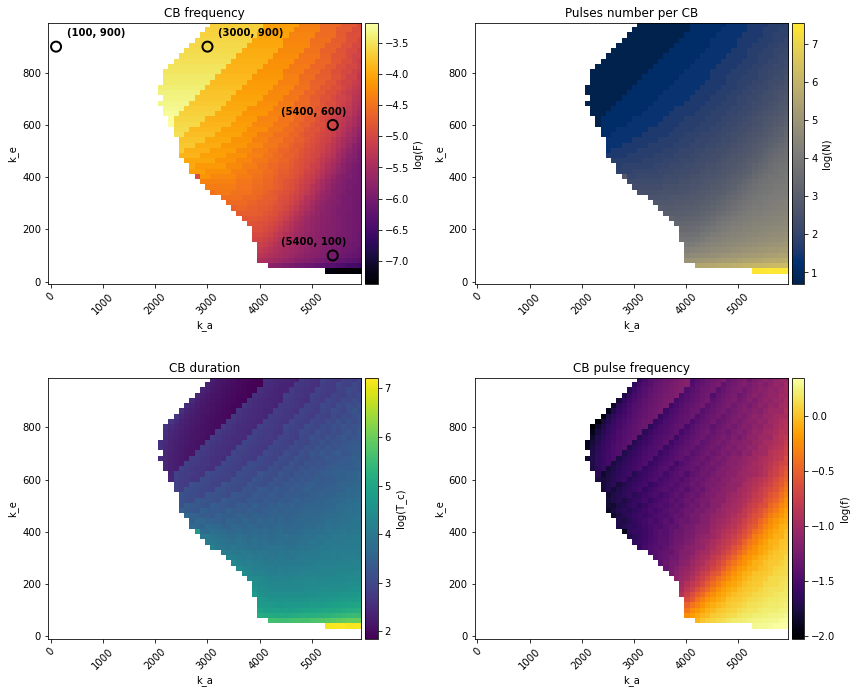

In [138]:
fig = plt.figure(figsize=(12, 10))
(ax1, ax2), (ax3, ax4) = fig.subplots(2, 2)

# CB frequency
im1 = ax1.imshow(np.log(1/cb_cycle_time_mat.T), aspect='equal', cmap='inferno')
ax1.set_xlabel('k_a')
ax1.set_ylabel('k_e')
ax1.set_xticks(range(0, 60, 10))
ax1.set_xticklabels(k_a_li[::10], rotation=45)
ax1.set_yticks(range(0, 50, 10))
ax1.set_yticklabels(k_e_li[::10])
ax1.invert_yaxis()
ax1.set_title('CB frequency')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(im1, cax=cax)
cbar.set_label('log(F)')


# CB Pulse Number
im2 = ax2.imshow(np.log(pulse_number_per_cb_mat.T), aspect='equal', cmap='cividis')
ax2.set_xlabel('k_a')
ax2.set_ylabel('k_e')
ax2.set_xticks(range(0, 60, 10))
ax2.set_xticklabels(k_a_li[::10], rotation=45)
ax2.set_yticks(range(0, 50, 10))
ax2.set_yticklabels(k_e_li[::10])
ax2.invert_yaxis()
ax2.set_title('Pulses number per CB')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(im2, cax=cax)
cbar.set_label('log(N)')

# CB duration
im3 = ax3.imshow(np.log(cb_duration_mat.T), aspect='equal', cmap='viridis')
ax3.set_xlabel('k_a')
ax3.set_ylabel('k_e')
ax3.set_xticks(range(0, 60, 10))
ax3.set_xticklabels(k_a_li[::10], rotation=45)
ax3.set_yticks(range(0, 50, 10))
ax3.set_yticklabels(k_e_li[::10])
ax3.invert_yaxis()
ax3.set_title('CB duration')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(im3, cax=cax)
cbar.set_label('log(T_c)')

# CB pulse frequency
im4 = ax4.imshow(np.log(pulse_number_per_cb_mat.T / cb_duration_mat.T), aspect='equal', cmap='inferno')
ax4.set_xlabel('k_a')
ax4.set_ylabel('k_e')
ax4.set_xticks(range(0, 60, 10))
ax4.set_xticklabels(k_a_li[::10], rotation=45)
ax4.set_yticks(range(0, 50, 10))
ax4.set_yticklabels(k_e_li[::10])
ax4.invert_yaxis()
ax4.set_title('CB pulse frequency')
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="4%", pad=0.05)
cbar = plt.colorbar(im4, cax=cax)
cbar.set_label('log(f)')

color = 'k'
ax1.scatter(100/100, 900/20, marker='o', color='none', edgecolors=[color], s=100, linewidths=[2])
ax1.text(100/100+2, 900/20+2, '(100, 900)', color=color, fontweight='bold')
ax1.scatter(3000/100, 900/20, marker='o', color='none', edgecolors=[color], s=100, linewidths=[2])
ax1.text(3000/100+2, 900/20+2, '(3000, 900)', color=color, fontweight='bold')
ax1.scatter(5400/100, 600/20, marker='o', color='none', edgecolors=[color], s=100, linewidths=[2])
ax1.text(5400/100-10, 600/20+2, '(5400, 600)', color=color, fontweight='bold')
ax1.scatter(5400/100, 100/20, marker='o', color='none', edgecolors=[color], s=100, linewidths=[2])
ax1.text(5400/100-10, 100/20+2, '(5400, 100)', color=color, fontweight='bold')



# plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('./output/ka_ke.png', dpi=300)
plt.show()